In [1]:
#Load packages

from scipy.stats import norm
from scipy.stats import t
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import seed
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings

In [2]:
df = pd.read_csv('pre_processed_data.csv')

In [3]:
df.drop('Unnamed: 0',axis = 1,inplace = True)

In [4]:
#Split data into training and testing splits
X = df.drop('Vehicle Ratio',axis = 1)
y = df['Vehicle Ratio']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25,random_state = 28)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20777, 16)
(6926, 16)
(20777,)
(6926,)


In [6]:
#Create dictionary to store scores for each model for easier comparison
model_eval = {}


In [7]:
#Will first try a linear regression model
#Create the model,fit to training data and evaluate score

lr_model = linear_model.LinearRegression()

lr_model.fit(X_train,y_train)

y_pred = lr_model.predict(X_test)


score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

#Add scores to model dictionary
model_eval['Linear reg'] = [score,rmse]


print ('Linear Regression r^2 =%.3f' % score)
print ('Linear Regression RMSE =%.3f' % rmse)
#Very high r^2 of 0.98!

Linear Regression r^2 =0.983
Linear Regression RMSE =0.038


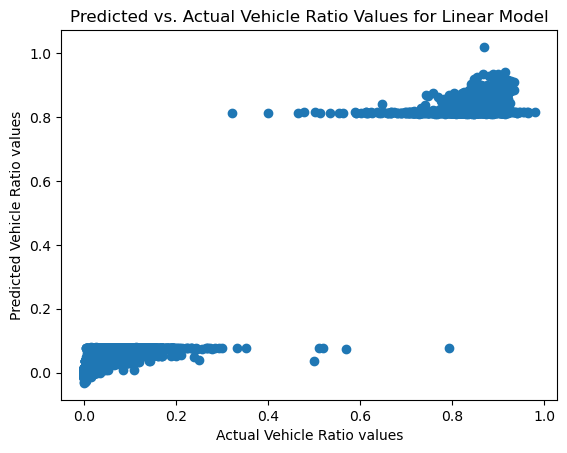

In [8]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Linear Model')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')

#Plot shows data is highly clustered but model is not robust enough to differentiate

In [9]:
#Try using multiple linear regression model

mult_lr_model = sm.OLS(y_train,X_train)

results = mult_lr_model.fit()

y_pred = results.predict(X_test)

score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['Multi lin reg'] = [score,rmse]

print ('Multi linear regression r^2 =%.3f' % score)
print ('Multi linear regression RMSE =%.3f' % rmse)

#Similar r-squared of 0.98. Appears largest correlation by far is to gasoline; model appears to just be fixed on
#imbalance in gasoline data points to generate predictions

Multi linear regression r^2 =0.983
Multi linear regression RMSE =0.038


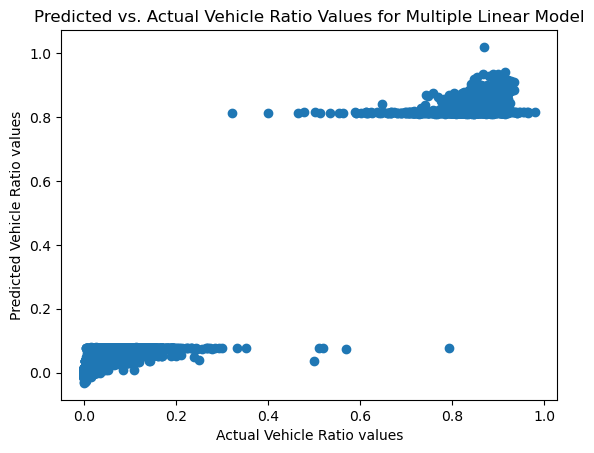

In [10]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Multiple Linear Model')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')

#Shows same issue, model not specific enough

In [11]:
#Will try Random Forest model 

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss


In [12]:
#Random Forest Regressor Model (no tuning) 

rf=  RandomForestRegressor(n_estimators=300, random_state = 1,n_jobs=-1)
rf_model = rf.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['Random forest (no tuning)'] = [score,rmse]

print ('Random Forest (no tuning) r^2 =%.3f' % score)
print ('Random Forest (no tuning) RMSE =%.3f' % rmse)


#Scores seem very good!

Random Forest (no tuning) r^2 =0.996
Random Forest (no tuning) RMSE =0.018


In [13]:
#Cross-validation just to ensure these results are not due to chance sampling\
from sklearn.model_selection import cross_val_score

print(cross_val_score(rf,X_train,y_train,scoring = 'neg_root_mean_squared_error'))

#Cross validation shows RMSE is closer to 0.022 rather than 0.018

[-0.01725415 -0.02050916 -0.01955246 -0.02169894 -0.01955071]


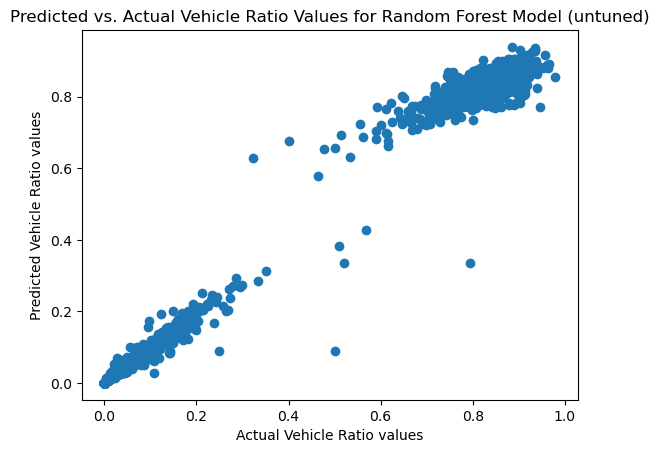

In [14]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Random Forest Model (untuned)')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')



#Plot shows better separation and more linear distribution compared to linear regression model;
#Random forest appears to have done better with different fuel classes; will need to improve on this by tuning 
# hyperparameters

16


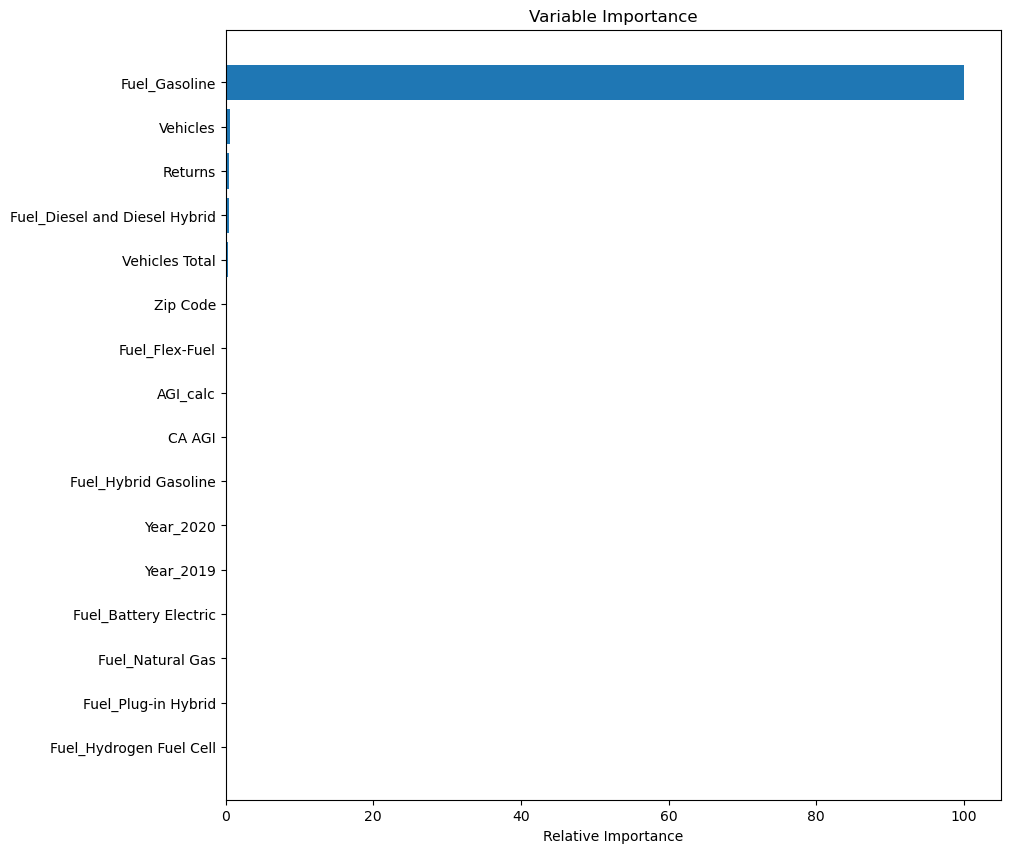

In [15]:
#Create plot of feature importance for random forest model (untuned)

feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#Shows model is almost completely dependent on gasoline fuel feature

In [16]:
#Hyperparameter tuning for Random Forest Regressor model using RandomizedSearchCV: 

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [17]:
# Use the random grid to search for best hyperparameters

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  17.5s


/Users/subikshc/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  17.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  17.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  32.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  32.4s
[CV] END bootstrap=True, max_depth=50, 

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  22.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  20.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  39.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  36.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  48.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  36.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  20.9s
[CV] END bootstrap=True, max_dept

/Users/subikshc/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
51 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/subikshc/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/subikshc/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/subikshc/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  F

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  46.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  45.0s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [18]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [22]:
#Random Forest Model with best hyperparameters

rf_tuned=  RandomForestRegressor(n_estimators= 800,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 20,
 bootstrap= False, 
  random_state = 1,n_jobs=-1)

rf_tuned.fit(X_train, y_train)


y_pred = rf_tuned.predict(X_test)

score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['Random forest (tuned)'] = [score,rmse]

print ('Random Forest (tuned) r^2 =%.3f' % score)
print ('Random Forest (tuned) RMSE =%.3f' % rmse)


Random Forest (tuned) r^2 =0.995
Random Forest (tuned) RMSE =0.022


In [23]:
print(cross_val_score(rf_tuned,X_train,y_train,scoring = 'neg_root_mean_squared_error'))

[-0.0202243  -0.02300994 -0.02267387 -0.02461072 -0.02206923]


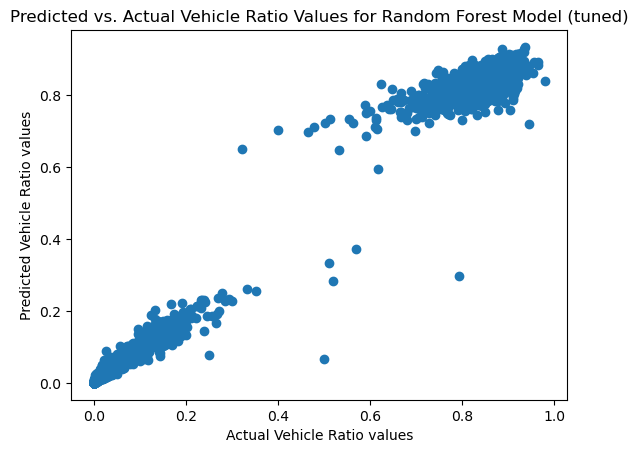

In [24]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Random Forest Model (tuned)')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')


In [25]:
# Tree based model seems to do better so will try another tree-based model. XGBoost does not perform well on sparse
#datasets (limited number of instances of less popular fuels in this dataset). Will try Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

In [26]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

In [27]:
score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))


print ('Gradient Boosting Regressor (not tuned) r^2 =%.3f' % score)
print ('Gradient Boosting Regressor (not tuned) RMSE =%.3f' % rmse)

#Performs very similar to tuned random forest

Gradient Boosting Regressor (not tuned) r^2 =0.991
Gradient Boosting Regressor (not tuned) RMSE =0.028


In [28]:
model_eval['Grad Boost Reg (not tuned)'] = [score,rmse]

In [29]:
model_eval

{'Linear reg': [0.9834179019421557, 0.03837395227638787],
 'Multi lin reg': [0.9834179019421556, 0.038373952276387985],
 'Random forest (no tuning)': [0.9961601692367599, 0.018466000094621758],
 'Random forest (tuned)': [0.9945432426147226, 0.022013247376745728],
 'Grad Boost Reg (not tuned)': [0.9911983897792862, 0.027957469357549954]}

In [30]:
#Hyperparameter tuning using RandomizedSearchCV for Gradient Boost
gbr_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1]}
#search=RandomizedSearchCV(estimator=gbr,param_distributions=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=3)

gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = gbr_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gbr_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [1, 2, 4],
                                        'n_estimators': [500, 1000, 2000],
                                        'subsample': [0.5, 0.75, 1]},
                   random_state=42, verbose=2)

In [31]:
gbr_params = gbr_random.best_params_
gbr_params

{'subsample': 0.75, 'n_estimators': 2000, 'max_depth': 2, 'learning_rate': 0.1}

In [32]:
#Train Gradient Boosting Regressor model using best hyperparameters from Randomized Search

gbr_tuned = GradientBoostingRegressor(subsample = 0.75, 
                                      n_estimators= 2000, 
                                      max_depth= 2, 
                                      learning_rate= 0.1)
gbr_tuned.fit(X_train, y_train)

y_pred = gbr_tuned.predict(X_test)

In [33]:
score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['Grad Boost Reg (tuned)'] = [score,rmse]

print ('Gradient Boosting Regressor (not tuned) r^2 =%.3f' % score)
print ('Gradient Boosting Regressor (not tuned) RMSE =%.3f' % rmse)

Gradient Boosting Regressor (not tuned) r^2 =0.996
Gradient Boosting Regressor (not tuned) RMSE =0.019


In [34]:
print(cross_val_score(gbr_tuned,X_train,y_train,scoring = 'neg_root_mean_squared_error'))

[-0.01698521 -0.01936912 -0.01942966 -0.02086254 -0.01791975]


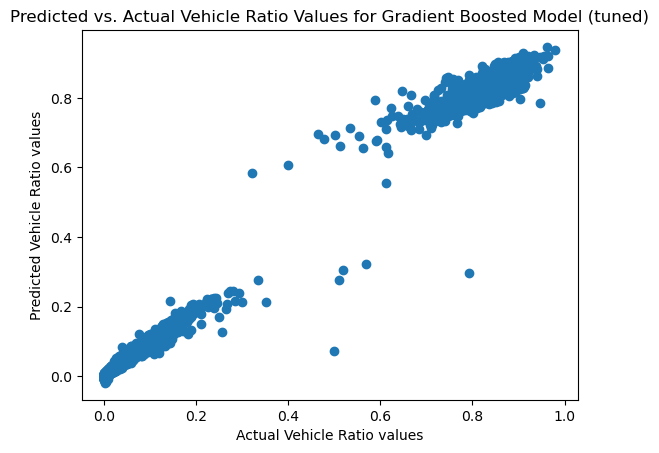

In [35]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Gradient Boosted Model (tuned)')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')

#Distribution especially for lower ratios looks improved

In [36]:
#Try KNN Regressor model by trying k neighbors between 1 through 10
from sklearn.neighbors import KNeighborsRegressor

test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))


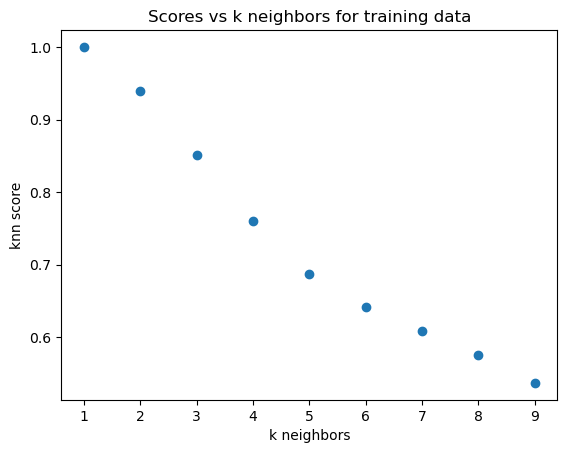

In [37]:
#Create plot to see scores vs. k neighbors for training data

_ = plt.scatter(x = np.arange(1,10),y = train_scores)
_ = plt.xlabel('k neighbors')
_ = plt.ylabel('knn score')
_ = plt.title('Scores vs k neighbors for training data')

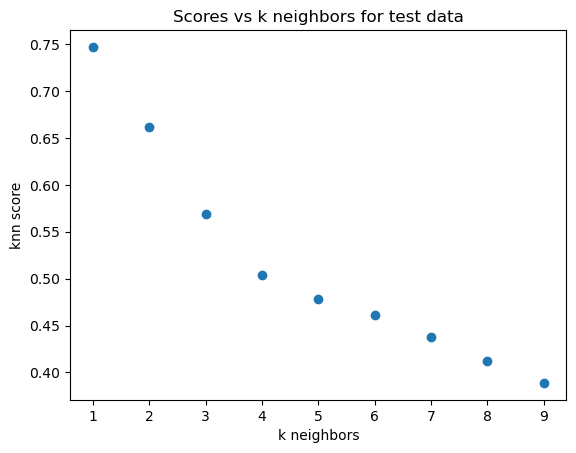

In [38]:
#Create plot to see scores vs. k neighbors for test data
_ = plt.scatter(x = np.arange(1,10),y = test_scores)
_ = plt.xlabel('k neighbors')
_ = plt.ylabel('knn score')
_ = plt.title('Scores vs k neighbors for test data')

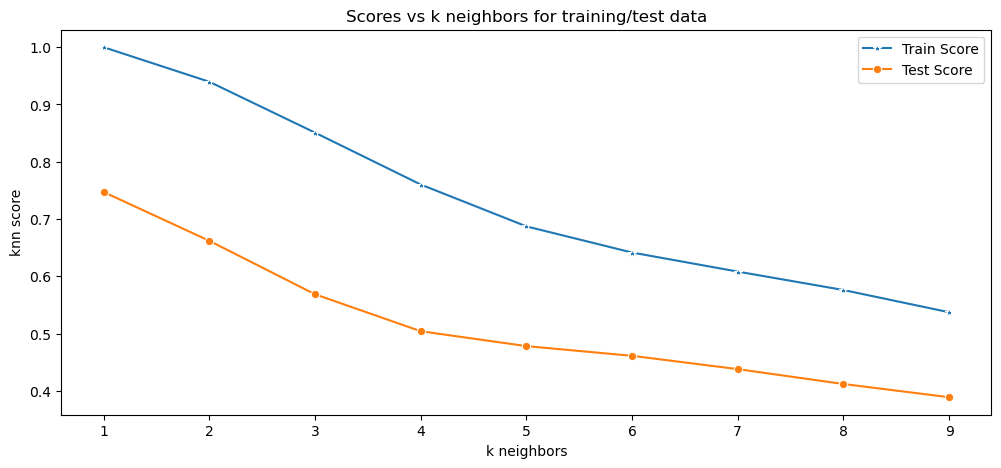

In [39]:
plt.figure(figsize=(12,5))
r = list(range(1,10))

p = sns.lineplot(x = r,y = train_scores,marker='*',label='Train Score')
p = sns.lineplot(x = r,y =test_scores,marker='o',label='Test Score')

_ = plt.xlabel('k neighbors')
_ = plt.ylabel('knn score')
_ = plt.title('Scores vs k neighbors for training/test data')

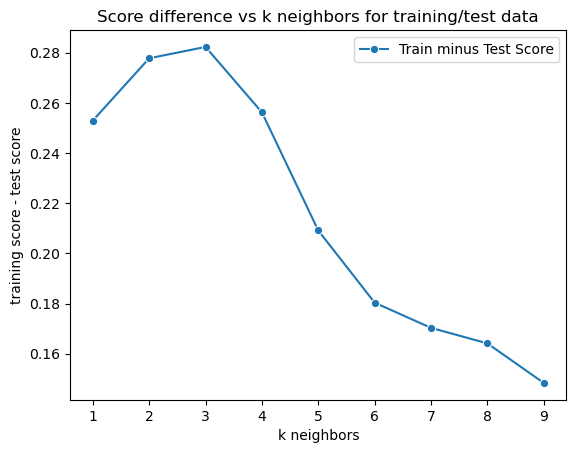

In [40]:
#Create plot to see minimum score difference between train and test score to see where they converge best. 

score_diffs = []
for i in range(0,9):
    
    score_diffs.append(train_scores[i] - test_scores[i])

p = sns.lineplot(x = r,y =score_diffs,marker='o',label='Train minus Test Score')

_ = plt.xlabel('k neighbors')
_ = plt.ylabel('training score - test score')
_ = plt.title('Score difference vs k neighbors for training/test data')

#k = 4 appears to be choice where difference is minimized but not too much accuracy has been lost (elbow point)

In [41]:
#KNN Regressor model using k = 4 

knn = KNeighborsRegressor(n_neighbors = 4)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['KNN (k=4)'] = [score,rmse]

print ('KNN Regressor r^2 =%.3f' % score)
print ('KNN Regressor RMSE =%.3f' % rmse)

#Appears to perform very poorly compared to tree-based models especially

KNN Regressor r^2 =0.504
KNN Regressor RMSE =0.210


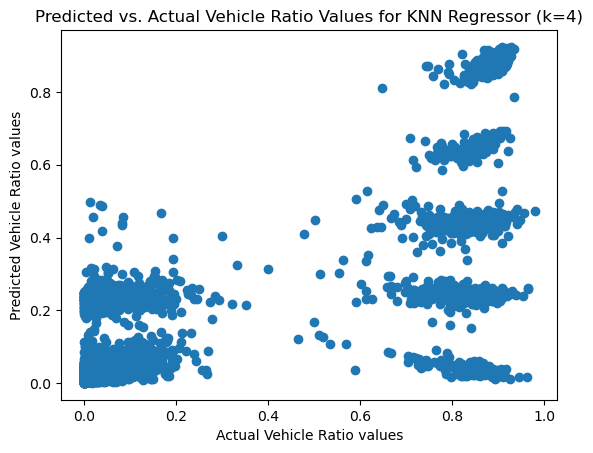

In [42]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for KNN Regressor (k=4)')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')


#As expected, very poor distribution...

In [43]:
model_eval

#Random Forest even with NO tuning appears to have done very well; maybe simpler tree ie. Decision Tree needs to be 
#explored

{'Linear reg': [0.9834179019421557, 0.03837395227638787],
 'Multi lin reg': [0.9834179019421556, 0.038373952276387985],
 'Random forest (no tuning)': [0.9961601692367599, 0.018466000094621758],
 'Random forest (tuned)': [0.9945432426147226, 0.022013247376745728],
 'Grad Boost Reg (not tuned)': [0.9911983897792862, 0.027957469357549954],
 'Grad Boost Reg (tuned)': [0.9961369784899762, 0.018521679070080645],
 'KNN (k=4)': [0.5040317133282488, 0.20986680234995633]}

In [44]:
#First try untuned Decision Tree

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['Decision Tree (not tuned)'] = [score,rmse]

print ('Decision Tree Regressor (not tuned) r^2 =%.3f' % score)
print ('Decision Tree Regressor (not tuned) RMSE =%.3f' % rmse)

Decision Tree Regressor (not tuned) r^2 =0.993
Decision Tree Regressor (not tuned) RMSE =0.026


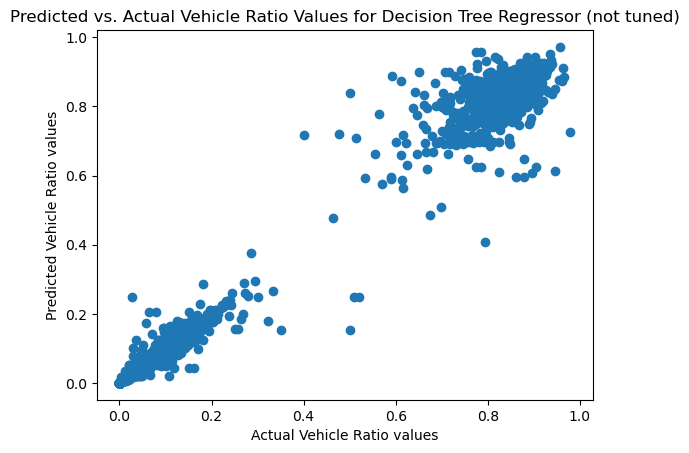

In [45]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Decision Tree Regressor (not tuned)')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')



In [46]:
#Hyperparameter tuning for Decision Tree using RandomizedSearchCV

dt_params = {'criterion':['squared_error','absolute_error'],
              'max_depth':np.arange(1,21).tolist()[0::2],
              'min_samples_split':np.arange(2,11).tolist()[0::2],
              'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

dt_random = RandomizedSearchCV(estimator = dt, param_distributions = dt_params, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dt_random.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 5, 7, 9, 11, 13,
                                                           15, 17, 19, 21, 23,
                                                           25],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   random_state=42, verbose=2)

In [47]:
dt_random.best_params_

{'min_samples_split': 4,
 'max_leaf_nodes': 21,
 'max_depth': 15,
 'criterion': 'squared_error'}

In [48]:
#Train Decision Tree using best params from RandomSearchCV

dt_tuned = DecisionTreeRegressor(min_samples_split = 4,
 max_leaf_nodes= 21,
 max_depth= 15,
 criterion= 'squared_error')

dt_tuned.fit(X_train, y_train)

y_pred = dt.predict(X_test)

score = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_eval['Decision Tree (tuned)'] = [score,rmse]

print ('Decision Tree Regressor (tuned) r^2 =%.3f' % score)
print ('Decision Tree Regressor (tuned) RMSE =%.3f' % rmse)

#Performs about the same as un-tuned

Decision Tree Regressor (tuned) r^2 =0.993
Decision Tree Regressor (tuned) RMSE =0.026


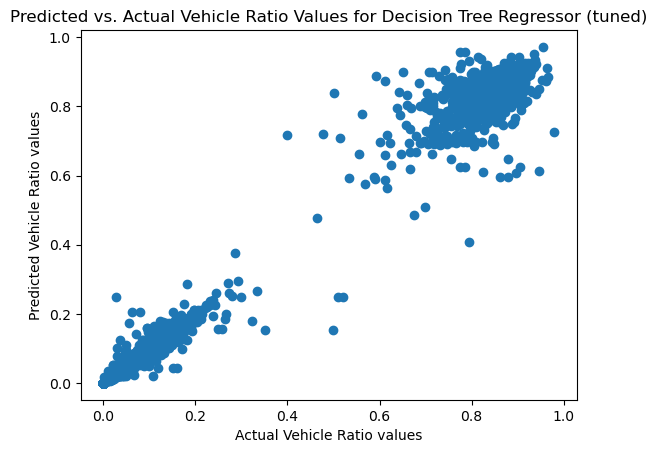

In [49]:
#Create scatter plot to see actual values vs. predicted values
_ = plt.scatter(y_test,y_pred)

_ = plt.title('Predicted vs. Actual Vehicle Ratio Values for Decision Tree Regressor (tuned)')
_ = plt.xlabel('Actual Vehicle Ratio values')
_ = plt.ylabel('Predicted Vehicle Ratio values')


In [50]:
#Create dataframe to easily compare all models
models = pd.DataFrame(model_eval)

In [51]:
models = models.T
models.columns = ['r^2','RMSE']
models

,r^2,RMSE
Linear reg,0.983418,0.038374
Multi lin reg,0.983418,0.038374
Random forest (no tuning),0.996160,0.018466
Random forest (tuned),0.994543,0.022013
Grad Boost Reg (not tuned),0.991198,0.027957
Grad Boost Reg (tuned),0.996137,0.018522
KNN (k=4),0.504032,0.209867
Decision Tree (not tuned),0.992644,0.025559
Decision Tree (tuned),0.992644,0.025559


In [52]:
models.sort_values('RMSE')

#Random Forest(no tuning) value was shown to be likely outlier by cross-validation. Gradient Boosting Regression
# appears to be best model in terms of minimizing loss function. However, if computation cost is of concern,
#Random forest model appears to be almost as good while not as as computationally expensive. 

,r^2,RMSE
Random forest (no tuning),0.996160,0.018466
Grad Boost Reg (tuned),0.996137,0.018522
Random forest (tuned),0.994543,0.022013
Decision Tree (not tuned),0.992644,0.025559
Decision Tree (tuned),0.992644,0.025559
Grad Boost Reg (not tuned),0.991198,0.027957
Linear reg,0.983418,0.038374
Multi lin reg,0.983418,0.038374
KNN (k=4),0.504032,0.209867
